# Modeling noise in the dilution experiment

In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0, '../../')
import scipy.misc
import mwc.stats
import mwc.bayes
import mwc.stats
import tqdm 
import mwc.viz
# Seed for reproducibility
np.random.seed(666)
colors = mwc.viz.personal_style()
%matplotlib inline

In this notebook, we will write lots and lots of text. 

## Simulating the dilution experiment 

In [140]:
# Define the constants of the simulation.
num_sim = 100 
alpha_true = 150 

# Set up the experiment using the magic of numpy arrays
prot_range = np.arange(10, 1000, 10)
ntot = np.array([prot_range for i in range(num_sim)])
n1 = np.random.binomial(ntot, 0.5)
n2 = ntot - n1

# Convert the counts to intensities using alpha_true
i1 = n1 * alpha_true
i2 = n2 * alpha_true
itot = ntot * alpha_true

# Make it a DataFrame
flat_transpose = np.array([n1.flatten(), n2.T.flatten(), ntot.flatten(), 
                           i1.flatten(), i2.flatten(), i1.flatten() + i2.flatten()]).T
sim_df = pd.DataFrame(flat_transpose, columns=['n_1', 'n_2', 'n_tot',
                                               'I_1', 'I_2', 'I_tot'])

# Compute the difference and fluctuations. 
sim_df.loc[:, 'fluct'] = np.diff(sim_df[['I_1', 'I_2']])**2

# Compute the averages for each protein copy number.
grouped = sim_df.groupby('n_tot').mean()

# Compute the theoretical curve.
I_tot_range = np.linspace(itot.min(), itot.max(), 500)
truth = alpha_true * I_tot_range 

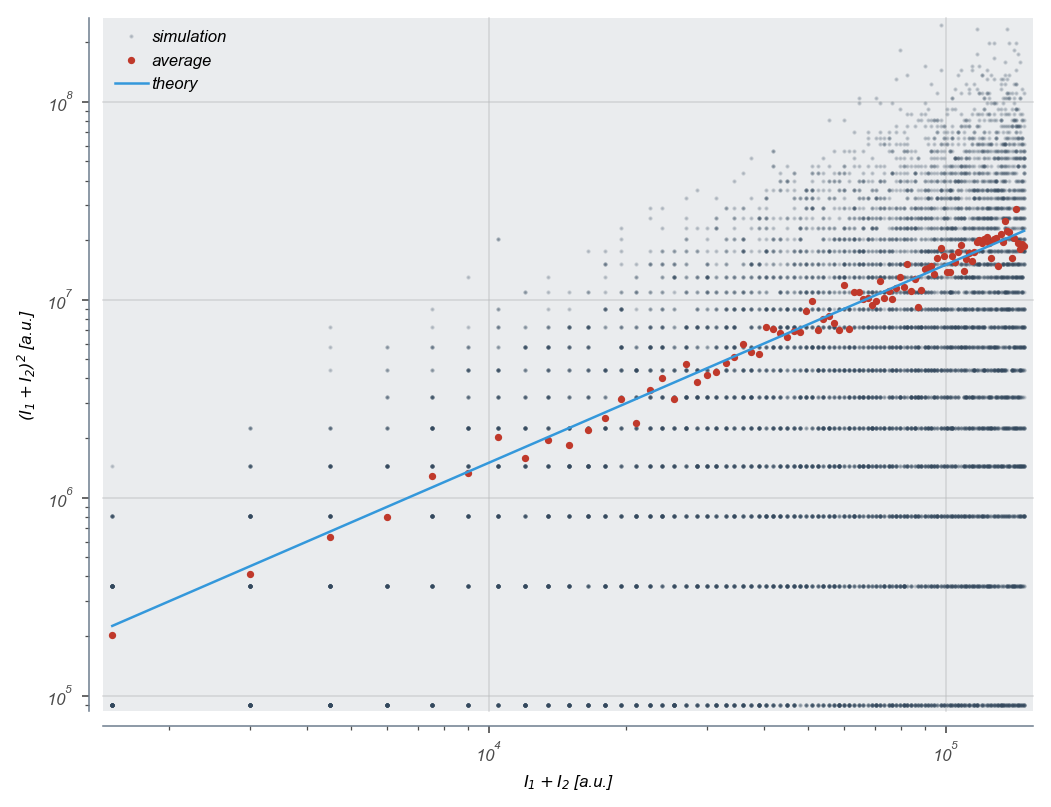

In [141]:
# Set up the figure canvas
fig, ax = plt.subplots(1,1)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('$I_1 + I_2$ [a.u.]')
ax.set_ylabel('$(I_1 + I_2)^2$ [a.u.]')

# Plot the result
_ = ax.plot(sim_df['I_tot'], sim_df['fluct'], '.', ms=2, alpha=0.2, label='simulation')
_ = ax.plot(grouped['I_tot'], grouped['fluct'], '.', ms=5, label='average')
_ = ax.plot(I_tot_range, truth, '-', label='theory')
_ = ax.legend()
sns.despine(offset=7)

In [142]:
# Estimating the calibration factor. 
alpha_opt, alpha_std = mwc.bayes.estimate_calibration_factor(sim_df['I_1'], sim_df['I_2'])

In [143]:
alpha_opt, alpha_std

(150.25394405241113, 2.1217859803820489)

In [144]:
# Plot the log posterior.
alpha_range = np.linspace(100, 200, 500)
log_post = np.zeros(len(alpha_range))
for i, a in enumerate(alpha_range):
    log_post[i] = mwc.bayes.deterministic_log_posterior(a, sim_df['I_1'], sim_df['I_2'],
                                                       neg=False)
    
# Renormalize the log posterior for plotting.
posterior = np.exp(log_post - scipy.special.logsumexp(log_post))

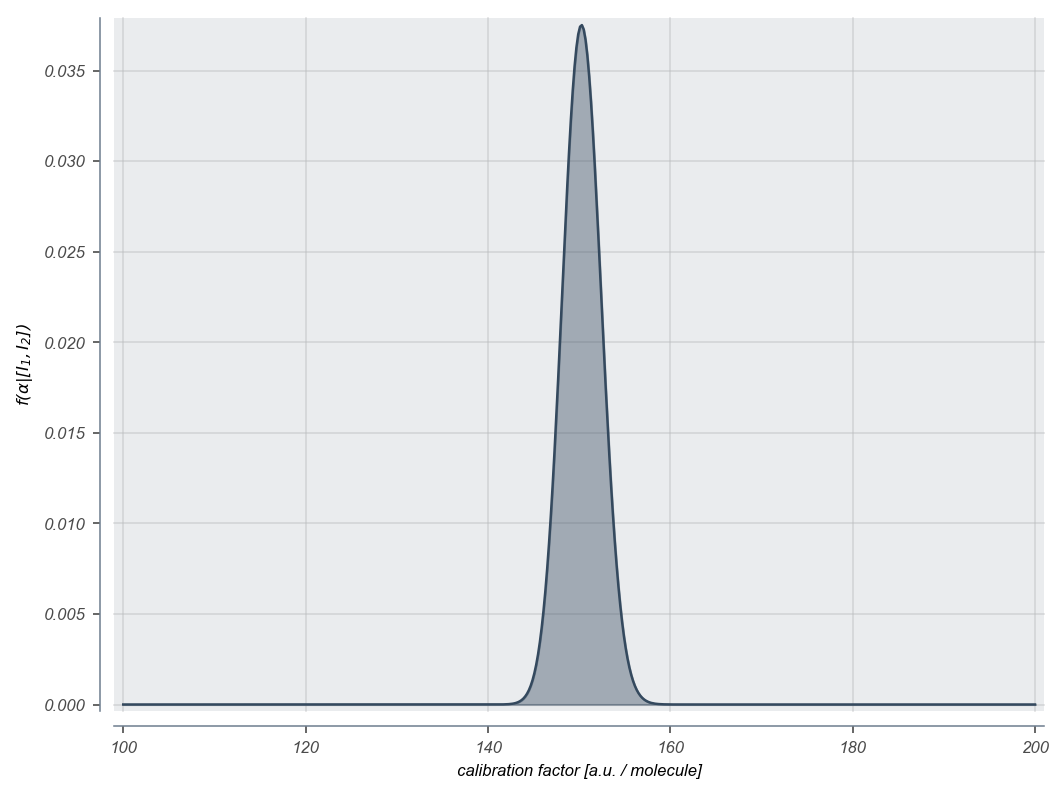

In [145]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('calibration factor [a.u. / molecule]')
ax.set_ylabel(r'$f(\alpha\vert [I_1, I_2])$')
_ = ax.plot(alpha_range, posterior)
_ = ax.fill_between(alpha_range, posterior, color=colors[0], alpha=0.4)
sns.despine(offset=7)

##  Model I: Simple Measurement Noise

Our model is
$$
I = \alpha N + \epsilon
$$

where $\epsilon$ is normally distributed.

In [179]:
# Define noise in fractional units of cellular intensity
noise_range = np.logspace(-5, 0, 500)
alpha_est = np.zeros_like(noise_range)
for i, ep in enumerate(noise_range): 
    i1 = sim_df['I_1']+ np.random.normal(0, ep * np.max(sim_df['I_1']))
    i2 = sim_df['I_2']+ np.random.normal(0, ep * np.max(sim_df['I_2']))
    exp_df = pd.DataFrame(np.array([i1, i2]).T, columns=['i1', 'i2'])
    exp_df = exp_df[exp_df >= 0]
    est, err = mwc.bayes.estimate_calibration_factor(exp_df['i1'], exp_df['i2'])
    alpha_est[i] = est

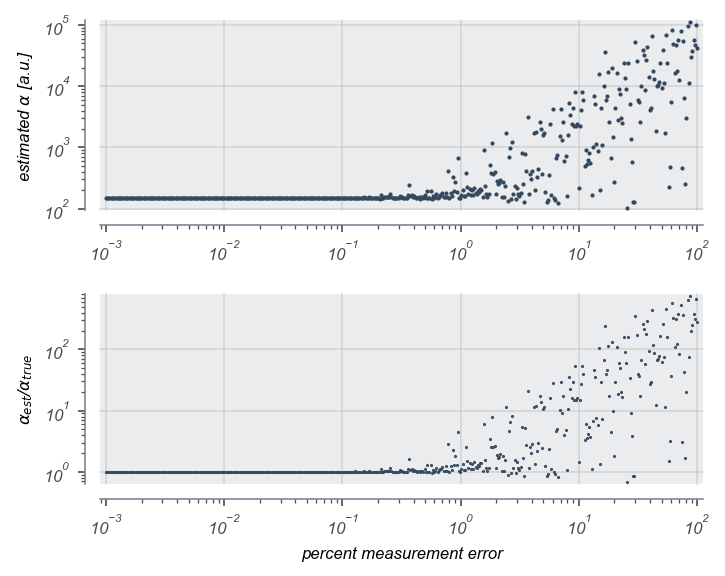

In [185]:
fig, ax = plt.subplots(2, 1, figsize=(5, 4), sharex=True)
ax[1].set_xlabel('percent measurement error')
for a in ax:
    a.set_xscale('log')
    a.set_yscale('log')

    
ax[0].set_ylabel(r'estimated $\alpha$ [a.u.]')
ax[1].set_ylabel(r'$\alpha_\mathrm{est} / \alpha_\mathrm{true}$')
_ = ax[0].plot(noise_range * 100, alpha_est,'.', markersize=2) 
_ = ax[1].plot(noise_range * 100, alpha_est / alpha_true, '.',
              markersize=True)

mwc.viz.format_axes()
plt.tight_layout()

In [183]:
est

42407.459993803575